# Explainable Machine Learning for Breast Cancer Subtype Classification Using TCGA RNA-seq Data

## Introduction

Breast cancer is a heterogeneous disease characterized by distinct molecular subtypes that differ in prognosis, treatment response, and underlying biology. Large-scale transcriptomic profiling from resources such as **The Cancer Genome Atlas (TCGA)** enables systematic investigation of these molecular signatures. In this notebook, we analyze the **TCGA Breast Invasive Carcinoma (BRCA)** RNA-seq dataset, which provides genome-wide gene expression measurements and corresponding clinical annotations for several hundred tumor samples.

Our goal is to **build predictive models that classify breast cancer samples into their PAM50 molecular subtypes** — **Luminal A, Luminal B, HER2-enriched,** and **Basal-like** — based on gene expression profiles. 

We then train multiple machine learning models, including **XGBoost** and a **neural network**, to perform subtype classification. To move beyond prediction and toward **biological interpretability**, we apply the **SHAP (SHapley Additive exPlanations)** framework. SHAP quantifies each gene’s contribution to model predictions, allowing us to identify subtype-specific markers and evaluate whether models rely on biologically meaningful patterns. 

Together, these analyses demonstrate how explainable AI can link predictive performance with interpretable molecular insights in cancer genomics.

### Package imports

In [1]:
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import shap

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

seed=7
np.random.seed(seed)
torch.manual_seed(seed)


## Data processing

### Load data

The RNA-seq expression data from the TCGA-BRCA cohort is downloaded. Only samples with an assigned PAM50 molecular subtype (Luminal A, Luminal B, HER2-enriched, or Basal-like) are retained to ensure accurate label consistency. To focus on the most informative transcriptional features and reduce dimensionality, we select the 2,000 most variable genes across all samples based on their expression variance.

In [2]:
# Features
## https://linkedomics.org/data_download/TCGA-BRCA/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi
features = pd.read_csv('TGCA-BRCA/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi.txt', sep = '\t', index_col=0).T

# RNA expression
## https://linkedomics.org/data_download/TCGA-BRCA/Human__TCGA_BRCA__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct.gz
exp = pd.read_csv('TGCA-BRCA/Human__TCGA_BRCA__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct.gz', sep = '\t', index_col=0).T

# Drop samples with no annotation
samples = [x for x in features.PAM50.dropna().index.values if x in exp.index.values]

# Select top 2000 variable genes
gene_variances = exp.var(axis=0)
top_var_genes = gene_variances.sort_values(ascending=False).head(2000).index

X = exp.loc[samples,top_var_genes]
y = features.loc[samples,'PAM50']

print("Shape after selecting top 2000 variable genes:", X.shape)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(np.unique(y_enc))

Shape after selecting top 2000 variable genes: (826, 2000)


### Split train, validation and test set

This initial split ensure that all models are are evaluated on the same test set, for proper comparison. 

In [3]:
# Split data: train / val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_enc, test_size=15/100, stratify=y_enc, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=15/85, stratify=y_trainval, random_state=seed
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (578, 2000)
Validation set shape: (124, 2000)
Test set shape: (124, 2000)


## Predictive models

### XGBoost Classifier

We first train an **XGBoost** model to classify breast cancer samples into their PAM50 subtypes based on gene expression profiles. XGBoost is a gradient-boosted decision tree algorithm that performs well on high-dimensional biological data and naturally handles nonlinear relationships. It also provides built-in feature importance estimates, making it a strong baseline for both prediction and interpretability.

In [4]:
# Train XGBoost classifier
model_tree = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
)
model_tree.fit(X_trainval, y_trainval)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [5]:
# Accuracy check
acc = model_tree.score(X_test, y_test)
print("Test accuracy:", acc)

Test accuracy: 0.9193548387096774


The XGBoost classifier achieved an overall **accuracy of approximately 0.9** on the test set. This indicates that the model can reliably distinguish between the main PAM50 breast cancer subtypes based on gene expression patterns. 

### Neural Network Classifier

We also implement a **neural network (NN)** to classify breast cancer samples into PAM50 subtypes using gene expression data. Neural networks can capture complex, nonlinear interactions between genes that may not be easily detected by tree-based models. 

To improve generalization and prevent overfitting, the network includes **dropout** and **batch normalization** layers. Additionally, we apply **elastic net regularization** to encourage sparsity and reduce the influence of less informative genes. Training is controlled with an **early stopping** mechanism, which monitors validation loss and retains the model parameters corresponding to the best performance.

In [6]:
# Simple feed-forward NN
class GeneNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
# Early stopping utility
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.best_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = deepcopy(model.state_dict())
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore_best(self, model):
        if self.best_state:
            model.load_state_dict(self.best_state)

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3,
                l1_lambda=1e-4, l2_lambda=1e-4, patience=10, device="cpu"):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)  # L2 here
    stopper = EarlyStopper(patience=patience)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)

            # L1 penalty (Elastic Net)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1:03d}: train={train_loss:.4f}, val={val_loss:.4f}")

        if stopper(val_loss, model):
            print("Early stopping triggered.")
            break

    stopper.restore_best(model)
    return model

In [9]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

In [10]:
# Count number of classes
num_classes = len(np.unique(y_enc))

# Initialize model
model_nn = GeneNet(input_dim=X.shape[1], num_classes=num_classes)

# Train with early stopping
trained_model_nn = train_model(
    model_nn,
    train_loader,
    val_loader,
    num_epochs=200,
    patience=20,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
)

Epoch 001: train=1.4535, val=0.4094
Epoch 002: train=1.0974, val=0.3589
Epoch 003: train=0.9394, val=0.3015
Epoch 004: train=0.8244, val=0.2802
Epoch 005: train=0.7338, val=0.2813
Epoch 006: train=0.6477, val=0.2943
Epoch 007: train=0.5948, val=0.2912
Epoch 008: train=0.5399, val=0.2865
Epoch 009: train=0.5052, val=0.3472
Epoch 010: train=0.5121, val=0.3153
Epoch 011: train=0.5109, val=0.3068
Epoch 012: train=0.5460, val=0.3114
Epoch 013: train=0.5280, val=0.2571
Epoch 014: train=0.4974, val=0.2601
Epoch 015: train=0.4634, val=0.2766
Epoch 016: train=0.4332, val=0.3242
Epoch 017: train=0.4254, val=0.5020
Epoch 018: train=0.4948, val=0.4489
Epoch 019: train=0.5374, val=0.3632
Epoch 020: train=0.5068, val=0.3318
Epoch 021: train=0.4750, val=0.3698
Epoch 022: train=0.4823, val=0.3257
Epoch 023: train=0.4697, val=0.3508
Epoch 024: train=0.5073, val=0.4062
Epoch 025: train=0.5135, val=0.3918
Epoch 026: train=0.5502, val=0.3442
Epoch 027: train=0.5473, val=0.4037
Epoch 028: train=0.5327, val

In [11]:
# --- Final evaluation on test set ---
trained_model_nn.eval()
correct = 0
total = 0
criterion = torch.nn.CrossEntropyLoss()
test_loss = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = trained_model_nn(xb)
        loss = criterion(outputs, yb)
        test_loss += loss.item() * xb.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

test_loss /= total
test_acc = correct / total

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 0.2710
Test accuracy: 0.9194


The neural network achieved an accuracy of approximately **0.9** on the test set, which is similar to the performance of the XGBoost model. This indicates that both models capture the main transcriptional patterns distinguishing PAM50 subtypes. 

## SHAP: Interpreting Model Predictions

While predictive models can achieve high accuracy, understanding **why** they make certain decisions is crucial in genomics and clinical applications. **SHAP (SHapley Additive exPlanations)** is a framework that assigns each feature (in this case, each gene) a contribution to the model's output for a given sample.  

SHAP values are grounded in cooperative game theory and provide a consistent, additive measure of feature importance. Positive SHAP values indicate that a gene pushes the model prediction **toward** a specific subtype, while negative values push it **away**. By applying SHAP to our trained XGBoost and neural network models, we can identify **subtype-specific gene signatures**, compare feature importance across models, and gain biological insights into the transcriptional drivers of breast cancer subtypes.

### SHAP Analysis of the XGBoost Model

To interpret the XGBoost classifier, we computed **SHAP values** for each gene and each PAM50 subtype. SHAP quantifies how much each gene contributes to driving a sample toward or away from a given subtype prediction.

We then selected the **top 20 most influential genes** based on their mean absolute SHAP values across all subtypes. The stacked bar plot below shows the contribution of each gene to the predictions for each subtype. Each bar represents a gene, with colored segments indicating how much that gene influences the prediction of each subtype.  

This visualization highlights genes that strongly drive subtype classification and allows us to compare which features are important for different subtypes, providing interpretable insights into the molecular signatures recognized by the XGBoost model.

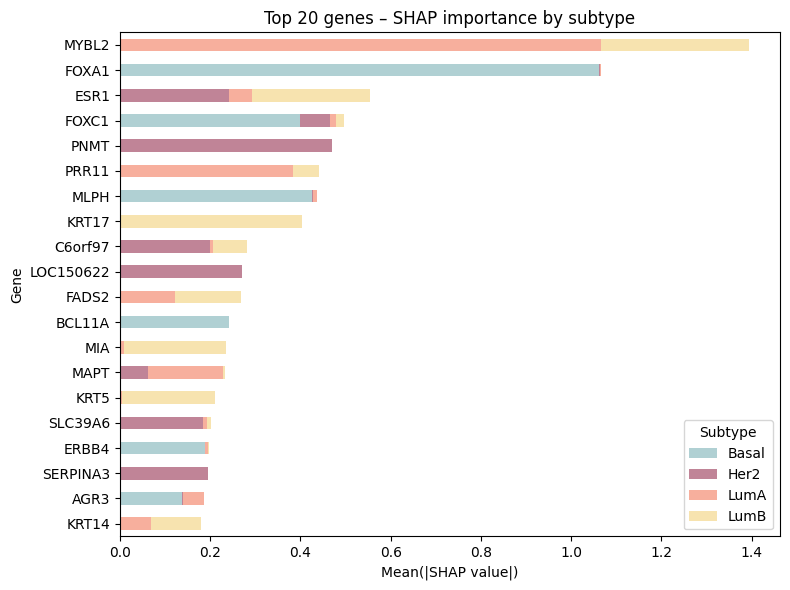

In [12]:
# Compute SHAP values
explainer = shap.TreeExplainer(model_tree)
shap_values_tree = explainer.shap_values(X_test)
class_names = le.classes_

# Compute mean SHAP value per gene per class
mean_abs = np.abs(shap_values_tree).mean(axis=0)  # → (n_features, n_classes)
shap_summary_tree = pd.DataFrame(mean_abs, columns=class_names, index=X.columns)

# Sort by total importance
shap_summary_tree["Total"] = shap_summary_tree.sum(axis=1)
shap_summary_tree = shap_summary_tree.sort_values("Total", ascending=False)

# Plot stacked importance
colors = ["#b0d0d3", "#c08497", "#f7af9d", "#f7e3af"]

shap_summary_tree.iloc[:20, :-1].plot(
    kind="barh",
    stacked=True,
    figsize=(8, 6), 
    color=colors
)
plt.gca().invert_yaxis()
plt.xlabel("Mean(|SHAP value|)")
plt.ylabel("Gene")
plt.title("Top 20 genes – SHAP importance by subtype")
plt.legend(title="Subtype")
plt.tight_layout()
plt.show()


We can illustrate the expression differences between subtypes with boxplots for the top 3 genes. 

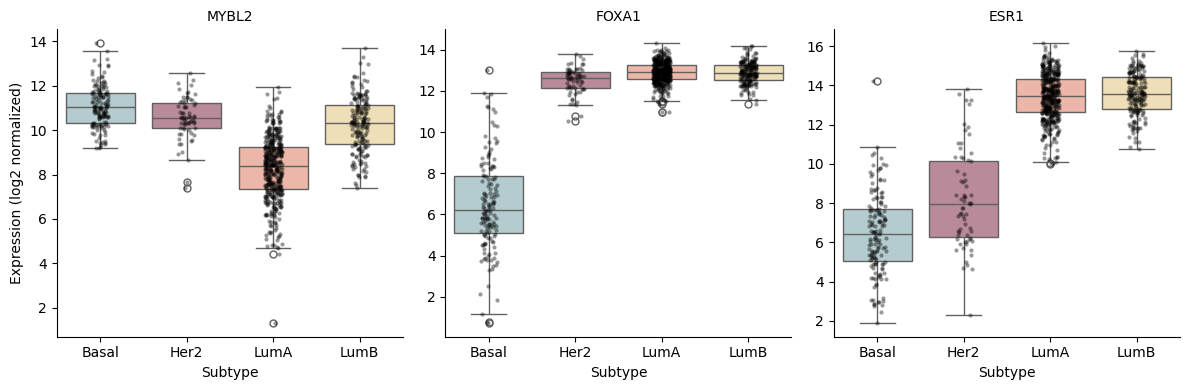

In [13]:
expr_long = (
    X[shap_summary_tree.index[:3]]
    .assign(Subtype=y)
    .melt(id_vars="Subtype", var_name="Gene", value_name="Expression")
)

# Sort subtypes alphabetically
expr_long["Subtype"] = pd.Categorical(expr_long["Subtype"], 
                                      categories=sorted(expr_long["Subtype"].unique()),
                                      ordered=True)

g = sns.catplot(
    data=expr_long,
    x="Subtype",
    y="Expression",
    col="Gene",
    kind="box",
    palette=colors,
    sharey=False,
    col_wrap=3,
    height=4
)
g.map_dataframe(sns.stripplot, x="Subtype", y="Expression", color="k", alpha=0.4, size=3)
g.set_titles("{col_name}")
g.set_axis_labels("Subtype", "Expression (log2 normalized)")
plt.tight_layout()
plt.show()


### SHAP Analysis of the Neural Network

We applied SHAP to the neural network to understand how gene expression contributes to subtype predictions. As with the XGBoost model, SHAP values quantify each gene's effect on the probability of each PAM50 subtype.

We selected the **top 20 genes with the highest mean absolute SHAP values** across all subtypes and plotted their contributions in a stacked bar chart. Unlike XGBoost, the neural network tends to distribute importance more evenly across many genes, reflecting its ability to integrate subtle, multigene signals. The plot allows us to see which genes most influence predictions for each subtype and how the network leverages complex interactions among features.

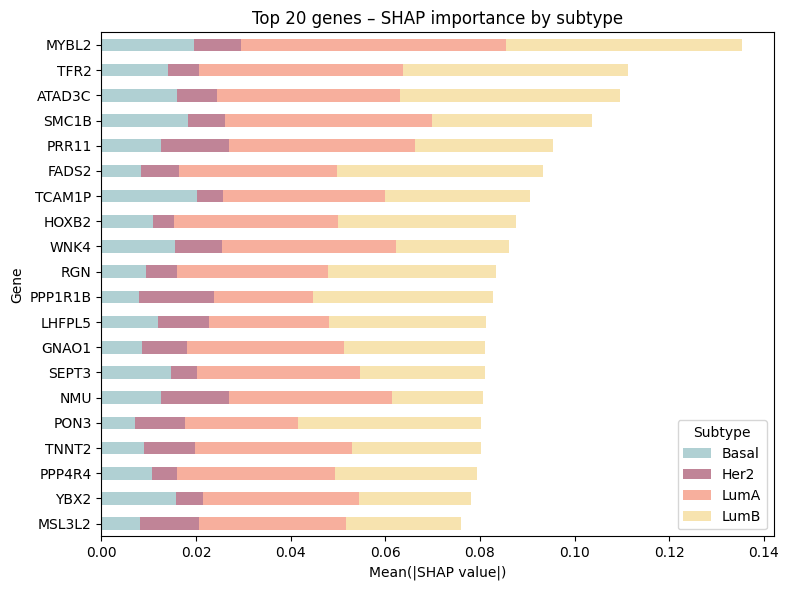

In [14]:
# Use a subset of training data as background
background = next(iter(train_loader))[0][:100]  # 100 samples

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(trained_model_nn, background)

# Compute SHAP values for selected samples
shap_values_nn = explainer.shap_values(X_test_tensor)

class_names = le.classes_

# Compute mean SHAP value per gene per class
mean_abs = np.abs(shap_values_nn).mean(axis=0)  # → (n_features, n_classes)
shap_summary_nn = pd.DataFrame(mean_abs, columns=class_names, index=X.columns)

# Sort by total importance
shap_summary_nn["Total"] = shap_summary_nn.sum(axis=1)
shap_summary_nn = shap_summary_nn.sort_values("Total", ascending=False)

# Plot stacked importance
colors = ["#b0d0d3", "#c08497", "#f7af9d", "#f7e3af"]

shap_summary_nn.iloc[:20, :-1].plot(
    kind="barh",
    stacked=True,
    figsize=(8, 6), 
    color=colors
)
plt.gca().invert_yaxis()
plt.xlabel("Mean(|SHAP value|)")
plt.ylabel("Gene")
plt.title("Top 20 genes – SHAP importance by subtype")
plt.legend(title="Subtype")
plt.tight_layout()
plt.show()

Again, we can illustrate the expression differences between subtypes with boxplots for the top 3 genes. 

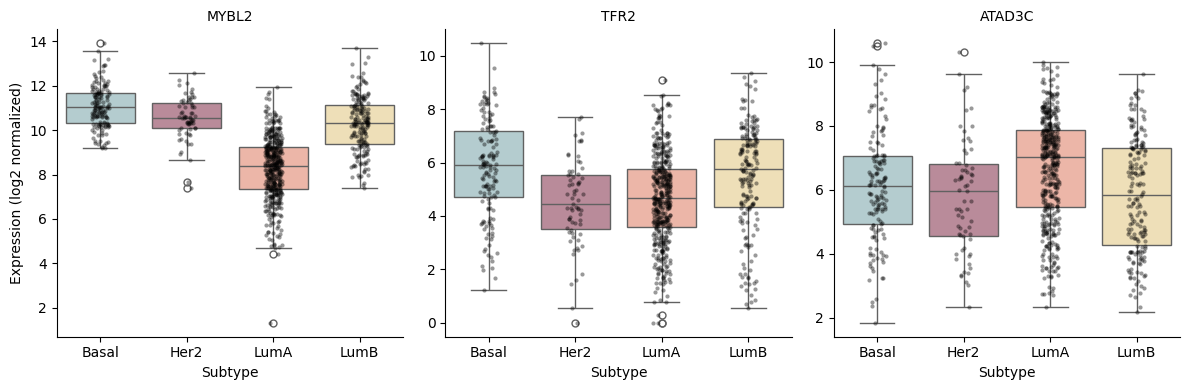

In [15]:
expr_long = (
    X[shap_summary_nn.index[:3]]
    .assign(Subtype=y)
    .melt(id_vars="Subtype", var_name="Gene", value_name="Expression")
)

# Sort subtypes alphabetically
expr_long["Subtype"] = pd.Categorical(expr_long["Subtype"], 
                                      categories=sorted(expr_long["Subtype"].unique()),
                                      ordered=True)

g = sns.catplot(
    data=expr_long,
    x="Subtype",
    y="Expression",
    col="Gene",
    kind="box",
    palette=colors,
    sharey=False,
    col_wrap=3,
    height=4
)
g.map_dataframe(sns.stripplot, x="Subtype", y="Expression", color="k", alpha=0.4, size=3)
g.set_titles("{col_name}")
g.set_axis_labels("Subtype", "Expression (log2 normalized)")
plt.tight_layout()
plt.show()

#### Observation on Neural Network SHAP Values

For the neural network model, we observe that **SHAP values are overall higher for the Luminal A and Luminal B subtypes** compared to HER2-enriched and Basal-like subtypes. This indicates that the model relies more heavily on specific genes to classify Luminal tumors, meaning that a few genes have a stronger influence on driving predictions toward these subtypes.  

In contrast, lower SHAP values for HER2 and Basal suggest that the network distributes predictive contributions across a larger number of genes, each with smaller individual effects. Biologically, this may reflect that Luminal subtypes are defined by a smaller set of dominant transcriptional markers, whereas HER2 and Basal tumors are characterized by broader, subtler patterns spread across many genes.


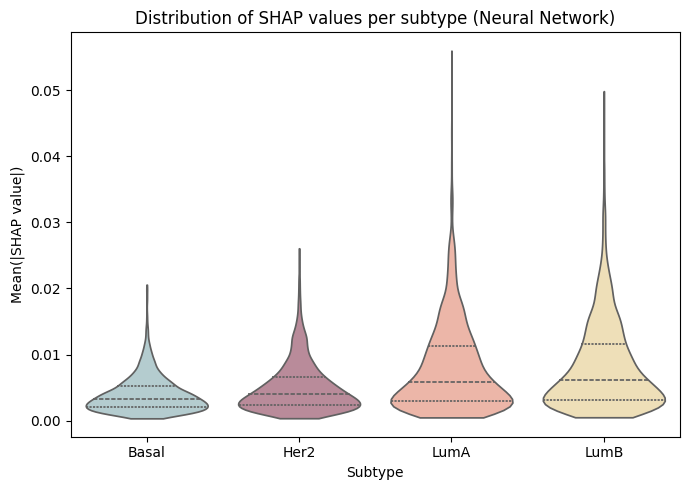

In [16]:
plt.figure(figsize=(7,5))
sns.violinplot(data=shap_summary_nn.drop('Total', axis=1), inner="quartile", palette=colors, cut=0)
plt.ylabel("Mean(|SHAP value|)")
plt.xlabel("Subtype")
plt.title("Distribution of SHAP values per subtype (Neural Network)")
plt.tight_layout()
plt.show()

### Comparison of Top Genes Between Models

When comparing the top 100 most important genes identified by SHAP for the XGBoost and neural network models, we observe **limited overlap**. This difference is expected and reflects the inherent characteristics of the two model types:

- **XGBoost** uses decision trees, which focus on **a few highly discriminative features**. Strong predictors dominate splits, so SHAP highlights a sparse set of genes with large contributions.  
- **Neural networks**, especially with dropout, batch normalization, and elastic net regularization, tend to **spread predictive influence across many correlated genes**. Each gene contributes moderately, capturing subtle, distributed patterns.

As a result, the models rely on different subsets of the transcriptome for classification. While XGBoost emphasizes a few high-impact markers, the neural network integrates broader multigene signals. Identifying genes that are consistently important across both models may provide the most robust candidates for biological validation.


Overlap: 20 genes
['C6orf97', 'DOC2B', 'DPYSL4', 'DSCR6', 'FADS2', 'FAM189A2', 'FOXC1', 'LOC100128977', 'LRRC50', 'MAPT', 'MOGAT2', 'MYBL2', 'PRR11', 'RASSF10', 'SEPT3', 'SMC1B', 'TCAM1P', 'TFR2', 'WNK4', 'YBX2']


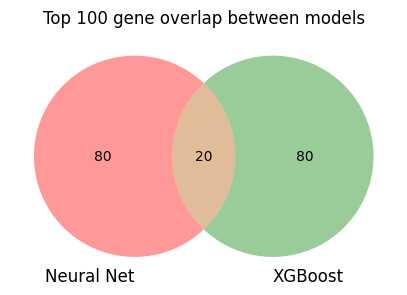

In [17]:
## Common genes in the top 50
top50_nn = shap_summary_nn.Total.sort_values(ascending=False).head(100).index
top50_tree = shap_summary_tree.Total.sort_values(ascending=False).head(100).index

overlap = set(top50_nn).intersection(set(top50_tree))
print(f"Overlap: {len(overlap)} genes")
print(sorted(list(overlap)))

plt.figure(figsize=(5,5))
venn2([set(top50_nn), set(top50_tree)], set_labels=('Neural Net', 'XGBoost'))
plt.title("Top 100 gene overlap between models")
plt.show()

## Conclusion

In this notebook, we trained two predictive models—**XGBoost** and a **neural network**—to classify breast cancer samples into PAM50 subtypes based on RNA-seq gene expression. Both models achieved high predictive performance, with **accuracy around 0.9** on the test set, demonstrating that the selected 2,000 most variable genes capture the key transcriptional differences among Luminal A, Luminal B, HER2-enriched, and Basal-like tumors.

SHAP analysis revealed notable differences in how each model distributes importance across genes. **XGBoost** relied heavily on a small set of high-impact genes, producing sparse and interpretable signatures, while the **neural network** spread contributions across many genes, reflecting its ability to integrate subtle, multigene interactions. Only a limited overlap existed between the top genes of each model, emphasizing that different architectures can capture complementary patterns.

Overall, combining predictive accuracy with SHAP-based interpretability provided insights into the molecular features driving subtype classification. As a next step, this framework could be extended to **multi-omics datasets**, integrating gene expression with copy number variation, methylation, or miRNA profiles to improve prediction and reveal more comprehensive molecular mechanisms underlying breast cancer heterogeneity.
